In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Sum,Recall,Accuracy,Precision,mape,AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.layers import Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.debugging.set_log_device_placement(True)
import Preloader
import Model
import utils

In [4]:
x_train, x_val, x_test, y_train, y_val, y_test = Preloader.direct_load(path="C:/Om/Data",sample=2000)


spliting data███████████████████████████████████████████████████████████████████████████████████████ 100% 2000/2000 creating_binary_masks


In [5]:
batch_size =32
gt,gtest,gval = Preloader.augment(x_train, x_val, x_test, y_train, y_val, y_test,batch_size)

In [ ]:
def yolo_v2_model(input_shape=(256,256,3)):
    input = Input(input_shape)

    def blocks(x,filters:int,block_no:int,max:int=1):
        y= Conv2D ( filters,(3,3),strides = (1,1),padding='same',name=f'conv{block_no}_1')(x)
        y= BatchNormalization(name=f"bnorm{block_no}")(y)
        y=Activation('relu')(y)
        if max:
            y= MaxPooling2D(pool_size=(2,2),name=f"maxpool{block_no}")(y)
        return y

    x = blocks(input,64,2)      #block 1
    x = blocks(x,128,3)     #block 2
    x = blocks(x,256,4)     #block 3
    x = blocks(x,512,5)     #block 4
    x = blocks(x,1024,6,max=0)    #block 5

    x = Conv2D(1,(3,3),strides=(1,1),padding='same',name="output_conv")(x)
    output = Flatten(name="output")(x)

    model = tf.keras.Model(inputs=[input], outputs=[output])
    model.summary()
    return model


In [2]:
import Model
model = Model.unet()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 256, 256, 512), (None, 512, 512, 512)]

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,Input,concatenate,Dropout,Conv2DTranspose,UpSampling2D,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

In [12]:
drop=0
drop!=0

False

In [14]:


def unet(normal=False):
    input_size = (256,256,3)
    filters = [64, 128, 256, 512, 1024]
    inputs = Input(input_size)
    def block_down(x,filter,pooling=True,drop=0,normal=False):
        layer1 = Conv2D(filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
        print("layer1")
        if normal:
            layer1 = BatchNormalization()(layer1)
        layer2 = Conv2D(filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        print("layer2")
        if normal:
            layer2 = BatchNormalization()(layer2)
        if drop>0:
        print("Drop=True")
            dropout = Dropout(drop)(layer2)
            print("Dropout")
            if pooling:
                pool = MaxPooling2D(pool_size=(2, 2))(dropout)
                print("Pooled Dropout")
                return pool,dropout 
            else:
                return dropout
        else:
            pool = MaxPooling2D(pool_size=(2, 2))(layer2)
            return pool,layer2

    def block_up(x,y,filter,normal=False):
        up = Conv2D(filter, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x))
        merge = concatenate([y,up], axis = 3) 
        conv = Conv2D(filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
        if normal:
            conv = BatchNormalization()(conv)
        conv = Conv2D(filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
        if normal:
            conv = BatchNormalization()(conv)
        return conv
        
    x,c1 = block_down(inputs,filters[0],normal=normal)
    x,c2 = block_down(x,filters[1],normal = normal)
    x,c3 = block_down(x,filters[2],normal= normal)
    x,c4 = block_down(x,filters[3],drop=0.5,normal =normal)

    x = block_down(x,filters[4],pooling = False,drop=0.5,normal =normal) #Branch

    x = block_up(x,c4,filters[3],normal=normal) #6
    x = block_up(x,c4,filters[2],normal=normal) #7
    x = block_up(x,c4,filters[1],normal=normal) #8
    x = block_up(x,c4,filters[0],normal=normal) #9

    x = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    if normal:
        x = BatchNormalization()(x)
            
    output = Conv2D(1, 1, activation = 'sigmoid')(x)

            
    

            
            
    #if no_pool==True:
    
    '''conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)'''
    model = Model( inputs,output)
    #model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


IndentationError: expected an indented block (2139885401.py, line 15)

In [15]:
unet()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 256, 256, 512), (None, 512, 512, 512)]

In [ ]:
with tf.device('/GPU:0'):
    model = Model.yolo_v2_model()
    #model.compile(optimizer = Adam(), loss = [dice_loss,'binary_crossentropy','hinge'] ,metrics = (Accuracy,AUC,Recall,Precision))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=[dice_loss, 'binary_crossentropy', 'hinge'], metrics=[Accuracy(), AUC(), Recall(), Precision()])

    history = model.fit(gt,epochs=50,verbose=1,validation_data=gval,callbacks = [checkpoint])#,early_stop,reducelr])

In [ ]:
checkpoints=utils.Checkpoints("UNet2")
with tf.device('/GPU:0'):
    model = Model.Unet1()
    #model.compile(optimizer = Adam(), loss = [dice_loss,'binary_crossentropy','hinge'] ,metrics = (Accuracy,AUC,Recall,Precision))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=utils.dice_loss)

    history = model.fit(gt,epochs=50,verbose=1,validation_data=gval,callbacks = [checkpoints])#,early_stop,reducelr])

AttributeError: module 'utils' has no attribute 'Checkpoints'

In [ ]:
#Load 
from Model import unet
model = unet()
model.load_weights("Checkpoints\Model1\Model1.cpkt")

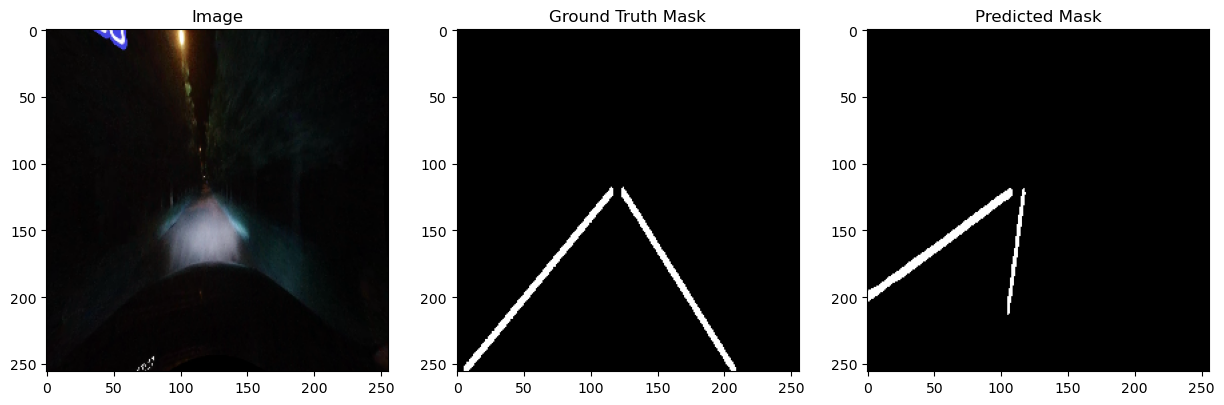

In [ ]:
test_gen = gtest

# Get one batch of test data
x_test, y_test = test_gen.next()

# Get the model prediction for the first image in the batch
pred = model.predict(x_test[31].reshape(1, 256, 256, 3))

# Convert the predicted mask to binary
pred_mask = (pred > 0.5).astype(np.uint8)[0]

# Visualize the image, ground truth mask, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x_test[0]*255)
axs[0].set_title('Image')

axs[1].imshow(y_test[0, :, :, 0], cmap='gray')
axs[1].set_title('Ground Truth Mask')

axs[2].imshow(pred_mask[:, :, 0], cmap='gray')
axs[2].set_title('Predicted Mask')

plt.show()